<a href="https://colab.research.google.com/github/ASTRONOE/Common_Data_Analysis/blob/master/Diamonds_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Diamond prices Analysis
## The purpose of this project is to analyze the diamond and see what features mostly determine their prices

##Features description
**Price** price in US dollars (\$326--\$18,823)

**Carat** weight of the diamond (0.2--5.01)

**Cut** quality of the cut (Fair, Good, Very Good, Premium, Ideal)

**Color** diamond colour, from J (worst) to D (best)

**Clarity** a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

**x** length in mm (0--10.74)

**y** width in mm (0--58.9)

**z** depth in mm (0--31.8)

**Depth** total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)

**Table** width of top of diamond relative to widest point (43--95)


---



**Carat** weight of the diamond

**Cut**
Describe cut quality of the diamond. Quality in increasing order Fair, Good, Very Good, Premium, Ideal

**Color**
Color of the diamond, with D being the best and J the worst

**Clarity**
How obvious inclusions are within the diamond:(in order from best to worst, FL = flawless, I3= level 3 inclusions) FL,IF, VVS1, VVS2, VS1, VS2, SI1, SI2, I1, I2, I3

**Depth**
The height of a diamond, measured from the culet to the table, divided by its average girdle diameter

**Table**
The width of the diamond's table expressed as a percentage of its average diameter

**Price**
the price of the diamond

**x**
length mm

**y**
width mm

**z**
breadth mm


##In this project, we will do an analysis of the diamond dataset to see what internal features influences diamond prices. We will do an
EDA
Feature engineering
Machine Learning


---

###We will first prepare the dataset

In [1]:
#load libraries
import time
import numpy as np
import random as rd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import graphviz
import statsmodels.api as sm
import statsmodels.stats.multicomp
import plotly.express as px
from google.colab import files
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from statsmodels.stats.anova import anova_lm#
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D
from statsmodels.formula.api import ols
from scipy.stats import f_oneway
from sklearn.preprocessing import MinMaxScaler, StandardScaler, SplineTransformer, OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.tree import export_graphviz
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
sb.set_style('darkgrid')
plt.rcParams.update({'figure.facecolor': 'grey', 'axes.grid': True})
# from scipy.optimize import curve_fi# from scipy.misc import derivative

In [2]:
#download the dataset
Df = pd.read_csv("https://raw.githubusercontent.com/ASTRONOE/Common_Data_Analysis/790daed175bce02199118fe6bf19938c913650ab/Kaggle/diamonds.csv")
print(Df.shape)
print(Df.info())
Df.head()

(53940, 10)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  int64  
 7   x        53940 non-null  float64
 8   y        53940 non-null  float64
 9   z        53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB
None


,carat,cut,color,clarity,depth,table,price,x,y,z
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
Df.describe()

,carat,depth,table,price,x,y,z
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


The dataset is large, and consists of both categorical and continuous variables. We will start by analysing the categorical or ordinal values to see how they affect the diamond prices. 

How is data distributed among the features that affect the diamond quality? We will convert the categorical values to ordinal values.

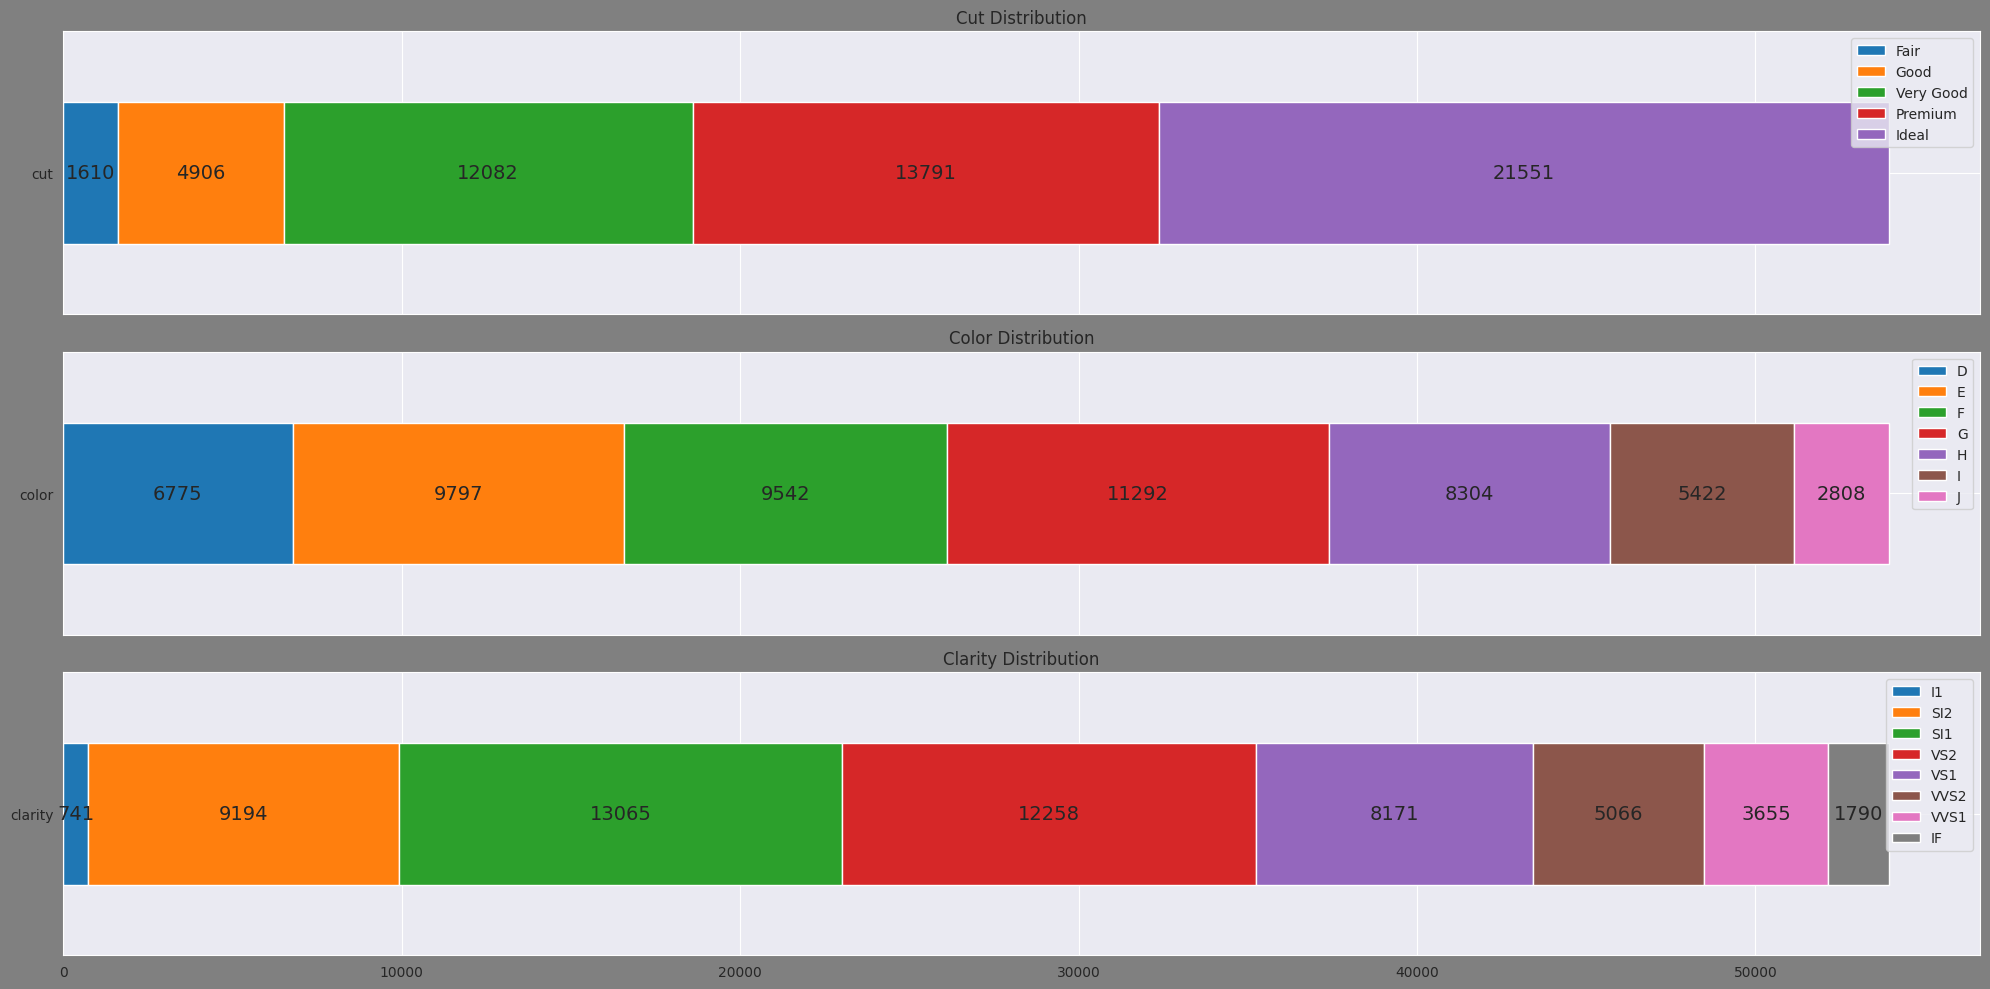

In [4]:
#Convert the categoral values to ordinal values
cut_level = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal'] #for cut
Df['cut'] = pd.Categorical(Df['cut'], categories=cut_level, ordered=True)
A = Df.cut.value_counts(ascending=True)

color_level = ['D', 'E', 'F', 'G', 'H', 'I', 'J'] #for color
Df['color'] = pd.Categorical(Df['color'], categories=color_level, ordered=True)
B = Df.color.value_counts().sort_index()

clarity_level = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF'] #for clarity
Df['clarity'] = pd.Categorical(Df['clarity'], categories=clarity_level, ordered=True)
C = Df.clarity.value_counts().sort_index()

#We plot a stacked bar chart of the distribution of categorical/ordnal values
f = ' Distribution'
fig, ax = plt.subplots(3, 1, figsize=(20, 10), sharex=True)
def placelabels(i):
  for c in ax[i].containers:
    ax[i].bar_label(c, label_type='center', size=14)

pd.DataFrame(A).T.plot(kind='barh', stacked=True, title='Cut'+f, ax=ax[0])
placelabels(0)
pd.DataFrame(B).T.plot(kind='barh', stacked=True, title='Color'+f, ax=ax[1])
placelabels(1)
pd.DataFrame(C).T.plot(kind='barh', stacked=True, title='Clarity'+f, ax=ax[2])
placelabels(2)
plt.tight_layout()
plt.show()

Much of the diamnonds have an 'ideal' cut quality. 'Clarity' and 'color' seem to show a normal distribution from worst to best but looks uniformly distributed around the middle.

###Now let us look at the overall price distribution.

The price distribution is a vastly exponentially skewed which means that most of the diamonds are very cheap, and expensive ones are rare.
As a result, we use the log of the price to see the distribution of price more clearly

In [5]:
Df['log_price'] = np.log(Df.price)
print(Df.log_price.head())
print(Df.price.describe())
print(Df.log_price.describe())

0    5.786897
1    5.786897
2    5.789960
3    5.811141
4    5.814131
Name: log_price, dtype: float64
count    53940.000000
mean      3932.799722
std       3989.439738
min        326.000000
25%        950.000000
50%       2401.000000
75%       5324.250000
max      18823.000000
Name: price, dtype: float64
count    53940.000000
mean         7.786768
std          1.014649
min          5.786897
25%          6.856462
50%          7.783641
75%          8.580027
max          9.842835
Name: log_price, dtype: float64


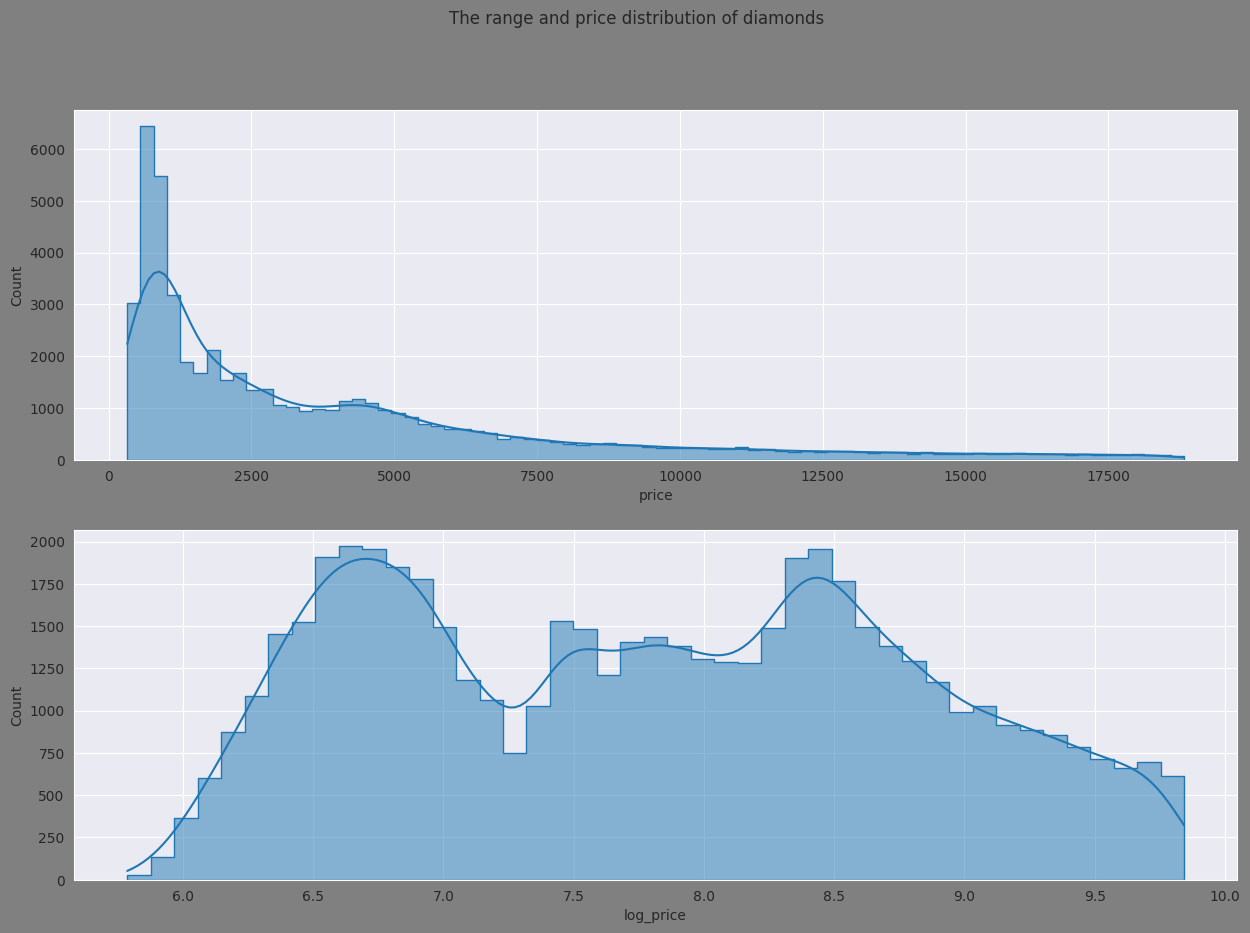

In [6]:
#diamond prices against quantity
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(15,10))
sb.set_style('darkgrid')
sb.histplot(data=Df, x='price', kde=True, element='step', ax=ax0)
sb.histplot(data=Df, x='log_price', kde=True, element='step', ax=ax1)
plt.suptitle("The range and price distribution of diamonds")
plt.show()

This is an exponential distribution. The amount of available diamonds exponentially drops as price increases.

###How do the categorical values correlate with the price?

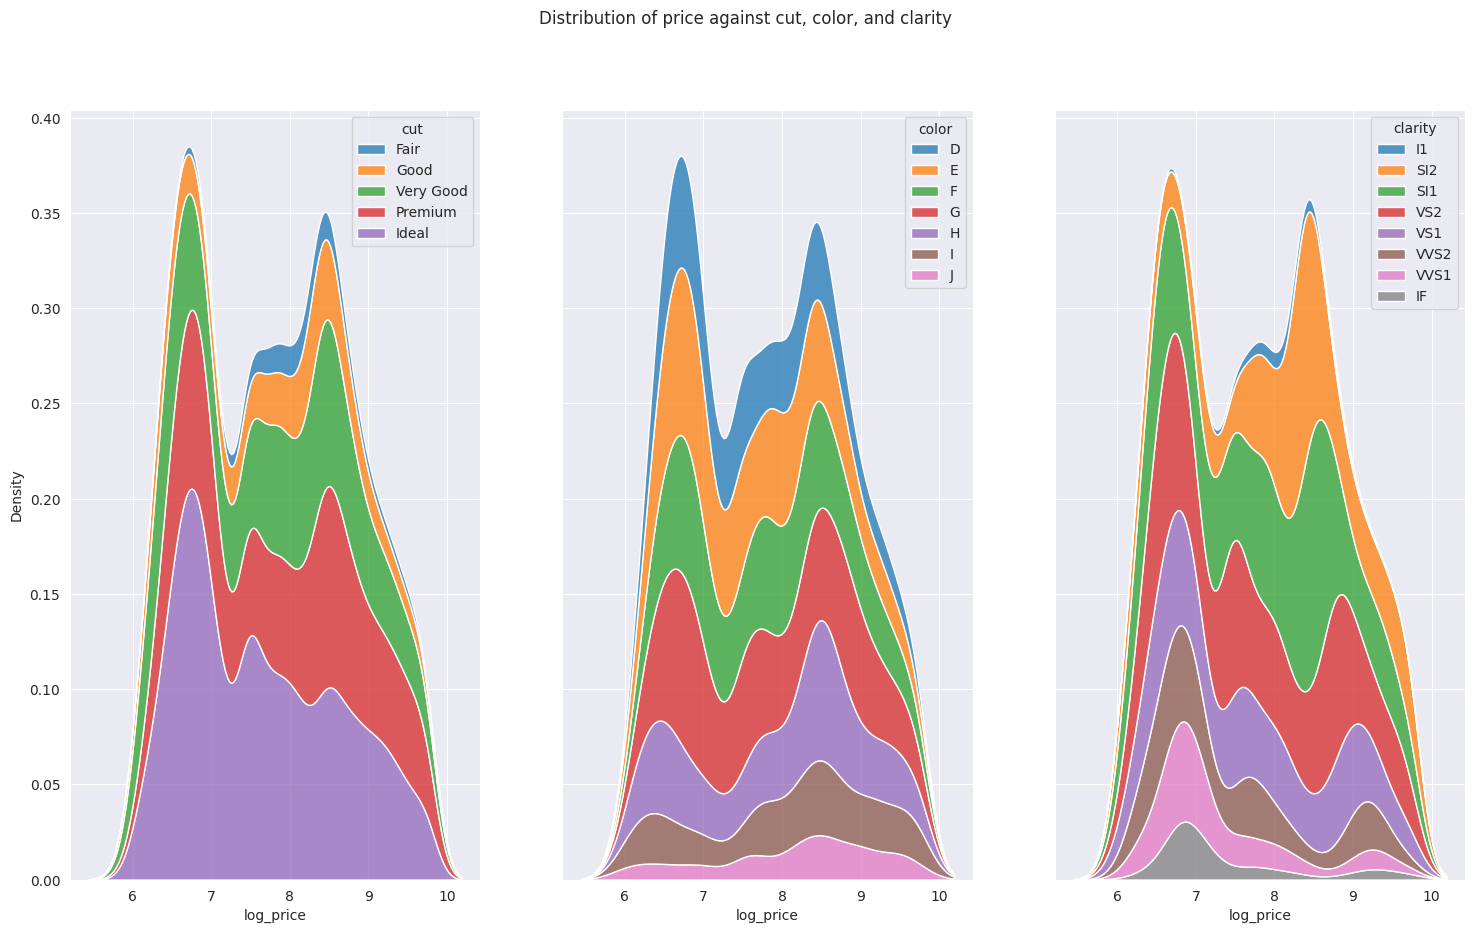

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(18, 10), sharex=True, sharey=True)
sb.kdeplot(data=Df, x='log_price', hue='cut', ax=ax[0], multiple='stack')
sb.kdeplot(data=Df, x='log_price', hue='color',ax=ax[1], multiple='stack')
sb.kdeplot(data=Df, x='log_price', hue='clarity', ax=ax[2], multiple='stack')
plt.suptitle("Distribution of price against cut, color, and clarity")
plt.show()

It seems that with better the clarity or color, the less the amount of diamonds in positive correlation with the price.


---

Now let's calculate the mean and median of price in each categorical feature to see which one affects the price of diamonds the most.

                mean median    len
               price  price  price
clarity                           
I1       3924.168691   3344    741
SI2      5063.028606   4072   9194
SI1      3996.001148   2822  13065
VS2      3924.989395   2054  12258
VS1      3839.455391   2005   8171
VVS2     3283.737071   1311   5066
VVS1     2523.114637   1093   3655
IF       2864.839106   1080   1790


<Axes: title={'center': 'Distribution of diamonds based on clarity with respect to their average price'}, xlabel='clarity'>

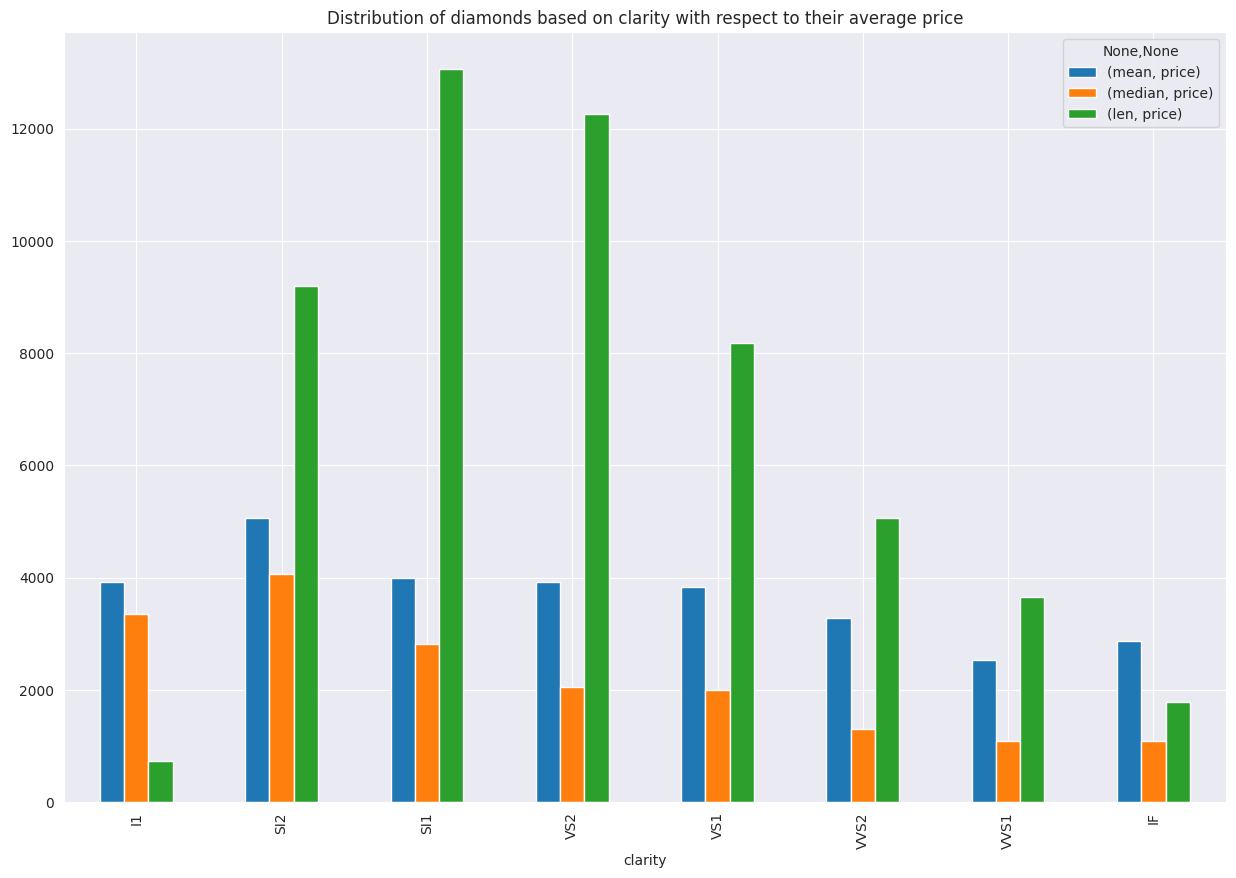

In [8]:
pivot_clarity = pd.pivot_table(data=Df, values=['price'], index=['clarity'], aggfunc=[np.mean, np.median, len])
print(pivot_clarity)

pivot_clarity.plot.bar(figsize=(15, 10), title="Distribution of diamonds based on clarity with respect to their average price")

It shows that diamonds become more expensive as their clarity improves. Il diamonds are very cheap, since their average price is far higher than the available amount. IF diamonds are extremely expensive. The mean price is way higher than their quantity. In general, a steep decline in quantity is noticed begining from SI1 even as averge price of diamonds gradually drops.

              mean  median    len
             price   price  price
color                            
D      3169.954096  1838.0   6775
E      3076.752475  1739.0   9797
F      3724.886397  2343.5   9542
G      3999.135671  2242.0  11292
H      4486.669196  3460.0   8304
I      5091.874954  3730.0   5422
J      5323.818020  4234.0   2808


<Axes: title={'center': 'Color quantity against mean and median price ratios'}, xlabel='color'>

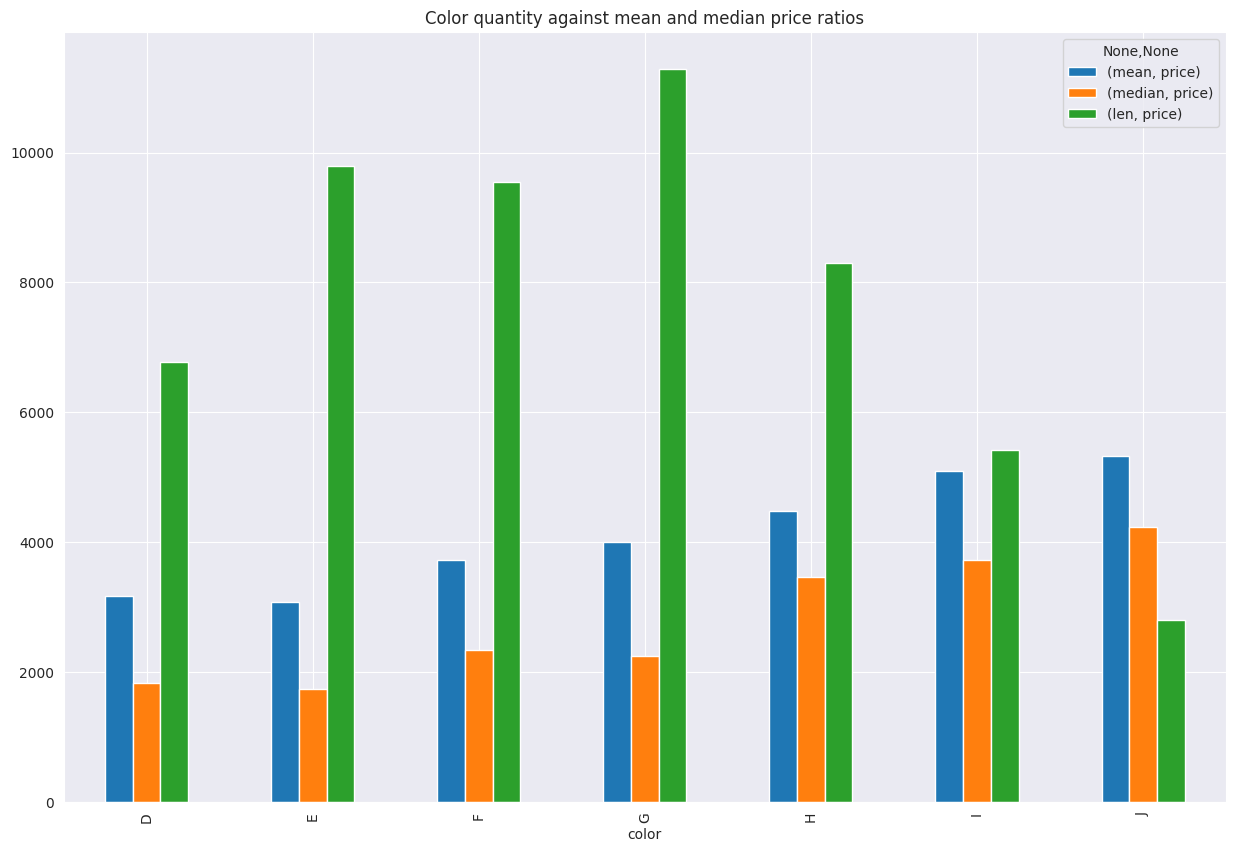

In [9]:
pivot_color = pd.pivot_table(data=Df, values=['price'], index=['color'], aggfunc=[np.mean, np.median, len])
print(pivot_color)

pivot_color.plot.bar(figsize=(15, 10), title="Color quantity against mean and median price ratios")

Color shows an ever increasing rice in average mean and median in price. The decline in quantity begins from G with J showing very few but also very expensive diamonds.

                  mean  median    len
                 price   price  price
cut                                  
Fair       4358.757764  3282.0   1610
Good       3928.864452  3050.5   4906
Very Good  3981.759891  2648.0  12082
Premium    4584.257704  3185.0  13791
Ideal      3457.541970  1810.0  21551


<Axes: title={'center': 'Clarity quantity[orange] against mean price[blue] ratio'}, xlabel='cut'>

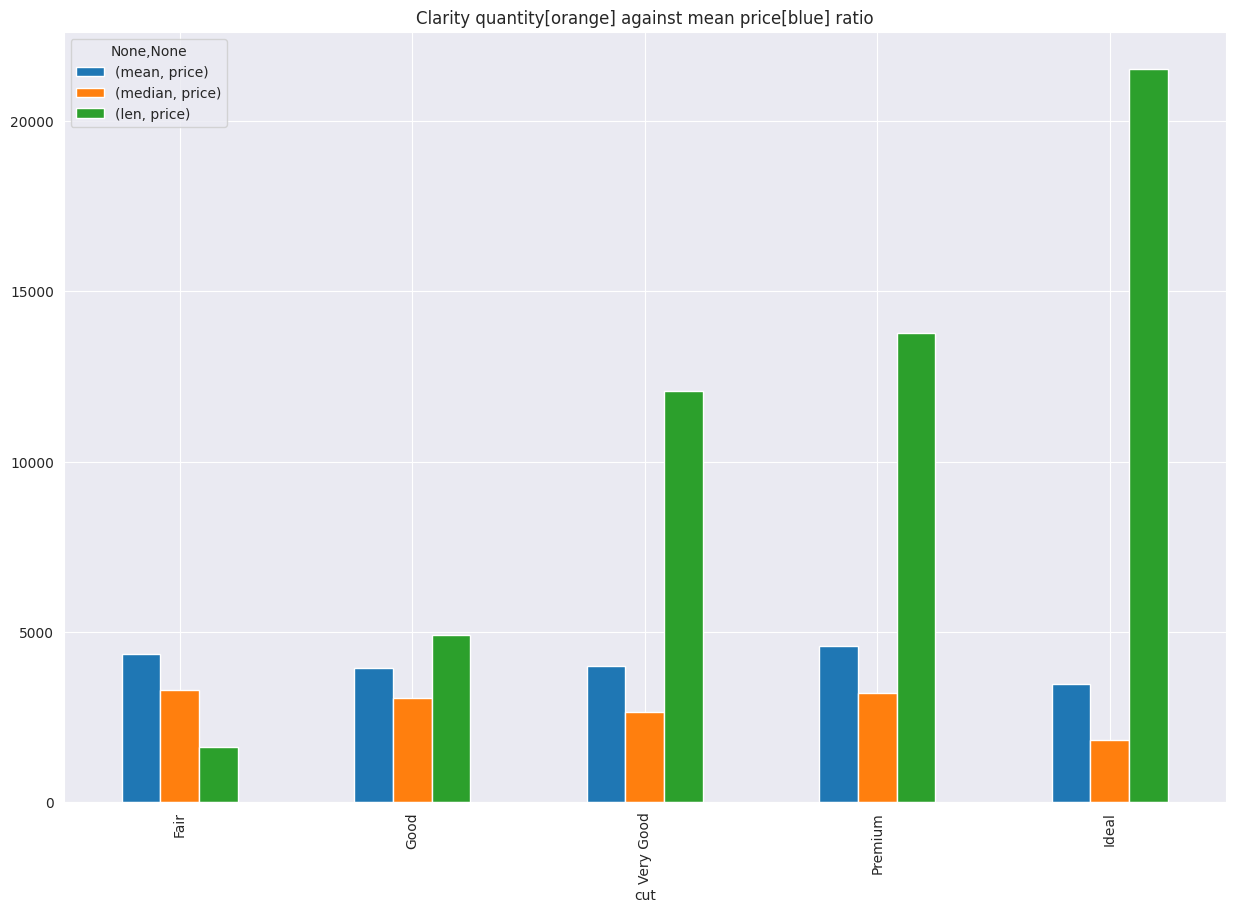

In [10]:
pivot_cut = pd.pivot_table(data=Df, values=['price'], index=['cut'], aggfunc=[np.mean, np.median, len])
print(pivot_cut)
pivot_cut.plot.bar(figsize=(15, 10), title="Clarity quantity[orange] against mean price[blue] ratio")

The cut column does not tell us if cut has an effect on price, based on this statistic.

---

Let's perform an ANOVA to test if cut influences diamond prices. Our null hypothesis is that the cut has no relation with the test.

In [11]:
# create a list of price data for each cut category
fair_prices = Df[Df['cut'] == 'Fair']['price']
good_prices = Df[Df['cut'] == 'Good']['price']
very_good_prices = Df[Df['cut'] == 'Very Good']['price']
premium_prices = Df[Df['cut'] == 'Premium']['price']
ideal_prices = Df[Df['cut'] == 'Ideal']['price']

# perform one-way ANOVA on the price data for each cut category
f_stat, p_value = f_oneway(fair_prices, good_prices, very_good_prices, premium_prices, ideal_prices)

print('F-statistic:', round(f_stat, 2))
print("p-value:, {:.2e}".format(p_value))

F-statistic: 175.69
p-value:, 8.43e-150



We use the f_oneway() function to do the ANOVA test. It turned out that our H0  failed. So we resort to OLS to see if it produces the same results. And the summary

In [12]:
# create a dummy variable for the cut column
cut_dummies = pd.get_dummies(Df['cut'], prefix='cut', drop_first=True)

# concatenate the dummy variable with the price and other columns
Df_model = pd.concat([Df[['price', 'carat', 'depth', 'table']], cut_dummies], axis=1)

# fit an OLS regression model
X = Df_model.drop('price', axis=1)
y = Df_model['price']
model = sm.OLS(y, X).fit()

# print the model summary
print(model.summary())

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.927
Model:                            OLS   Adj. R-squared (uncentered):              0.927
Method:                 Least Squares   F-statistic:                          9.850e+04
Date:                Thu, 13 Apr 2023   Prob (F-statistic):                        0.00
Time:                        23:49:53   Log-Likelihood:                     -4.7133e+05
No. Observations:               53940   AIC:                                  9.427e+05
Df Residuals:                   53933   BIC:                                  9.427e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                    coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------

It also invalidates H0 with R^2 of 92.0% and a p-value of 0.000 way below the consensus 0.05 value. So below we do a post hoc test.

In [13]:
tukey_results = pairwise_tukeyhsd(endog=Df['price'], groups=Df['cut'], alpha=0.05)

# Print the results
print(tukey_results.summary())

     Multiple Comparison of Means - Tukey HSD, FWER=0.05      
 group1   group2   meandiff p-adj    lower      upper   reject
--------------------------------------------------------------
   Fair      Good -429.8933 0.0015  -740.4593 -119.3273   True
   Fair     Ideal -901.2158    0.0 -1180.5808 -621.8507   True
   Fair   Premium  225.4999 0.1951   -59.2763  510.2762  False
   Fair Very Good -376.9979 0.0031  -663.8719  -90.1239   True
   Good     Ideal -471.3225    0.0  -642.3685 -300.2765   True
   Good   Premium  655.3933    0.0   475.6451  835.1414   True
   Good Very Good   52.8954 0.9341  -130.1581  235.9489  False
  Ideal   Premium 1126.7157    0.0  1008.8048 1244.6267   True
  Ideal Very Good  524.2179    0.0    401.327  647.1088   True
Premium Very Good -602.4978    0.0  -737.2377 -467.7579   True
--------------------------------------------------------------


Now let's draw two plots to visualize the extent of the distribution of our residuals.

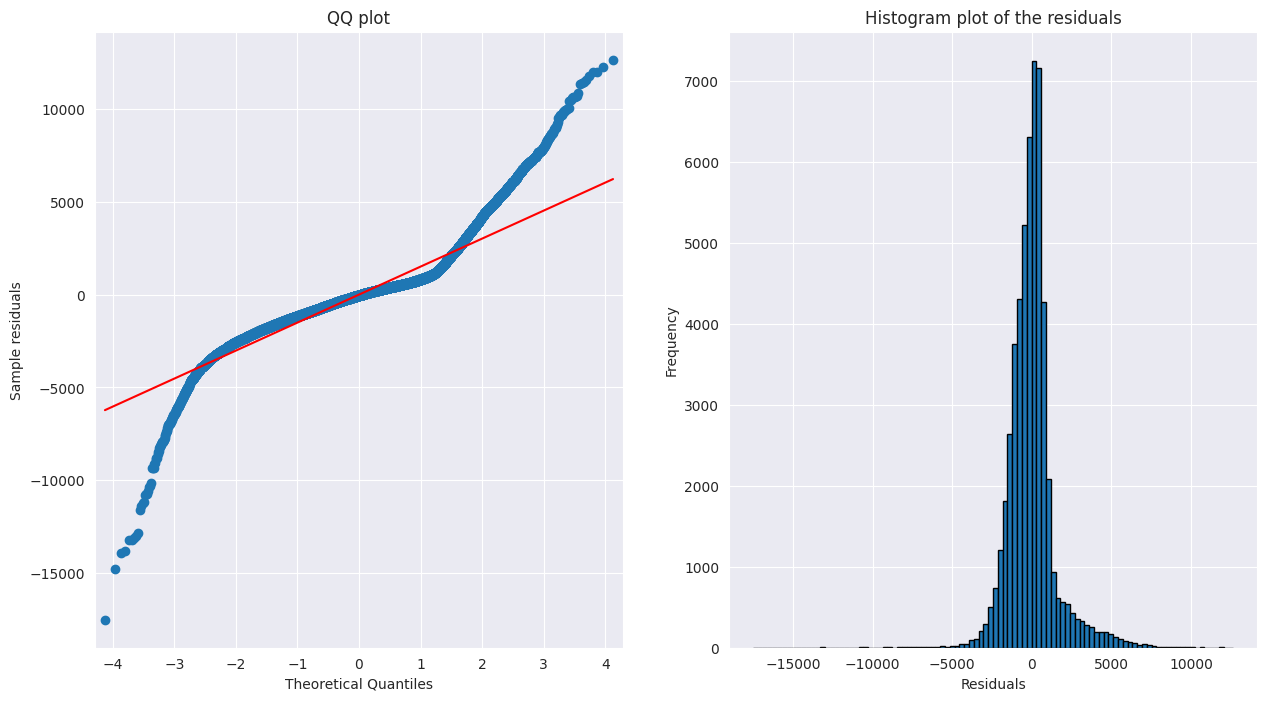

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
# Extract the residuals from the model
residuals = model.resid

# Create a QQ plot
sm.qqplot(residuals, line='s', ax=ax1)
ax1.set_ylabel("Sample residuals")
ax1.set_title("QQ plot")

# Create a histogram of the residuals
ax2.hist(residuals, bins=100, histtype='bar', ec='k')
ax2.set_xlabel("Residuals")
ax2.set_ylabel("Frequency")
ax2.set_title("Histogram plot of the residuals")
plt.show()

The variance of our data is extremely low because of the values of R^2.

### Now let us analyze the numerical data


---
We will start with the analysis of the weights or carats


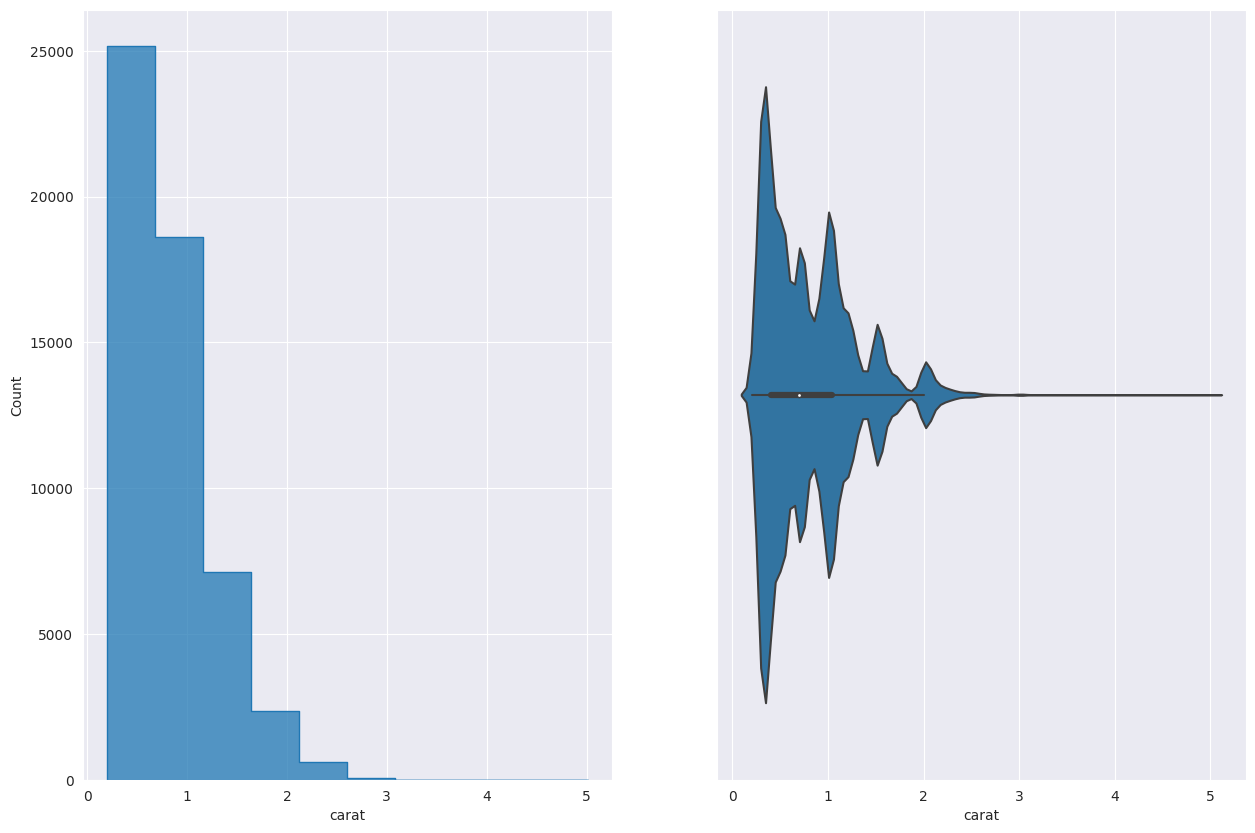

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
sb.histplot(data=Df, x='carat', bins=10, element='step', ax=ax[0])
sb.violinplot(data=Df, x='carat')
plt.show()

Like price, it is also exponential, which means that the vast majority of the diamonds are below 2.5 carats. So let us see how much diamonds are being skewed. What is the frequency of diamonds from 0 to 5 carats?

In [16]:
#create index of series of labels
labels = ['0~1kt', '1~2kt', '2~3kt', '3~4kt', '4~5kt', '5~6kt']
#split the carat column according to the bins of carats
kt_dist = pd.cut(Df['carat'], bins=range(0, 7), precision=1, labels=labels).value_counts()
#prices of diamonds from 0 to 5 carats
kt_dist

0~1kt    36438
1~2kt    15613
2~3kt     1857
3~4kt       27
4~5kt        4
5~6kt        1
Name: carat, dtype: int64

In [17]:
#reset index and rename the carats
count = kt_dist.reset_index().rename(columns={'index': 'carat_range', 'carat': 'count'})
print(count)

  carat_range  count
0       0~1kt  36438
1       1~2kt  15613
2       2~3kt   1857
3       3~4kt     27
4       4~5kt      4
5       5~6kt      1


In [18]:
count['mean_price'] = Df.groupby(pd.cut(Df['carat'], bins=range(0, 7), precision=1, labels=labels))['price'].mean().values
print(count)

  carat_range  count    mean_price
0       0~1kt  36438   1786.950683
1       1~2kt  15613   7607.724076
2       2~3kt   1857  14946.222940
3       3~4kt     27  14942.666667
4       4~5kt      4  16576.500000
5       5~6kt      1  18018.000000


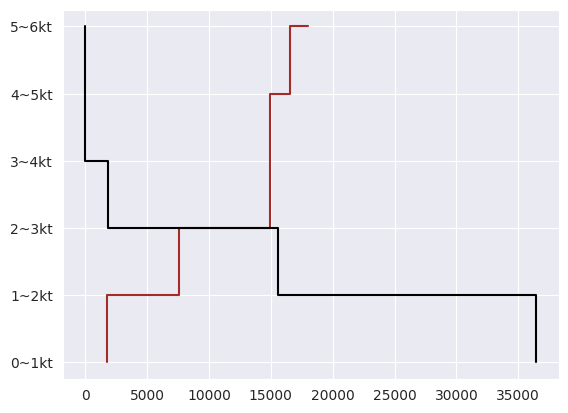

In [19]:
fig, ax = plt.subplots(sharex=True, sharey=True)
ax.step(x=count['mean_price'], y=count['carat_range'], color='brown')
ax.step(x=count['count'], y=count['carat_range'], color='black')
plt.show()

As the weights increase, there is an exponential drop in quantity but a very huge increase in price, as shown in the mean price. Even the only 5kt diamond is so expensive, it costs $18000

Next we look at the carat distribution against price

Text(0.5, 0.98, 'Diamond Prices by Carat and Price with frequency in color')

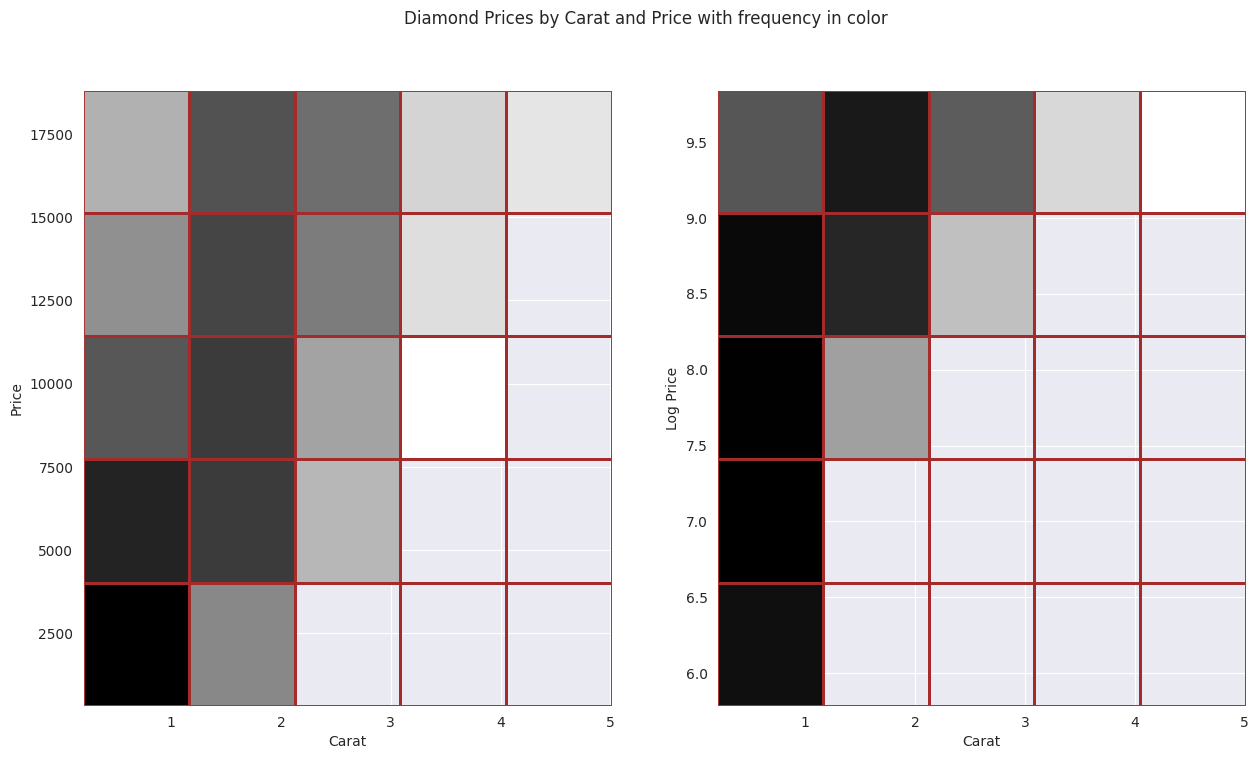

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(15, 8), sharex=True)
ax[0].hist2d(Df.carat, Df.price, bins=5, norm=colors.LogNorm(), cmap='binary', color='brown')
ax[1].hist2d(Df.carat, Df.log_price, bins=5, norm=colors.LogNorm(), cmap='binary', color='brown')
ax[0].set_xlabel('Carat')
ax[1].set_xlabel('Carat')
ax[0].set_ylabel('Price')
ax[1].set_ylabel('Log Price')
plt.suptitle('Diamond Prices by Carat and Price with frequency in color')

It shows that as the diamond carat and cost increase, they become fewer and fewer. Even the log of prices show us that much of the diamonds have only a carat of 1


We know that the heavier the diamonds, the more expensive and scarcer they become.

Now let us see the distribution of diamond quality ratings against their price and carat using a jointplot.
For the sake of visibility, we will draw only the tenth rows throughout the dataset.

In [21]:
Df1 = Df.iloc[::10, :].reset_index(drop=True)

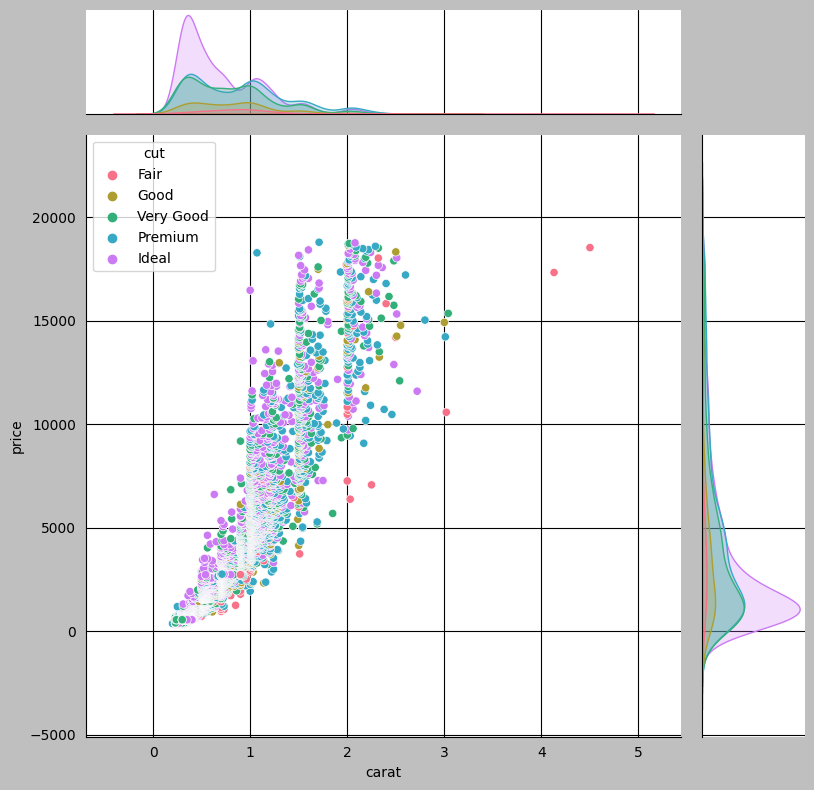

In [22]:
plt.style.use('grayscale')
sb.jointplot(x='carat', y='price', data=Df1, height=8, hue='cut')

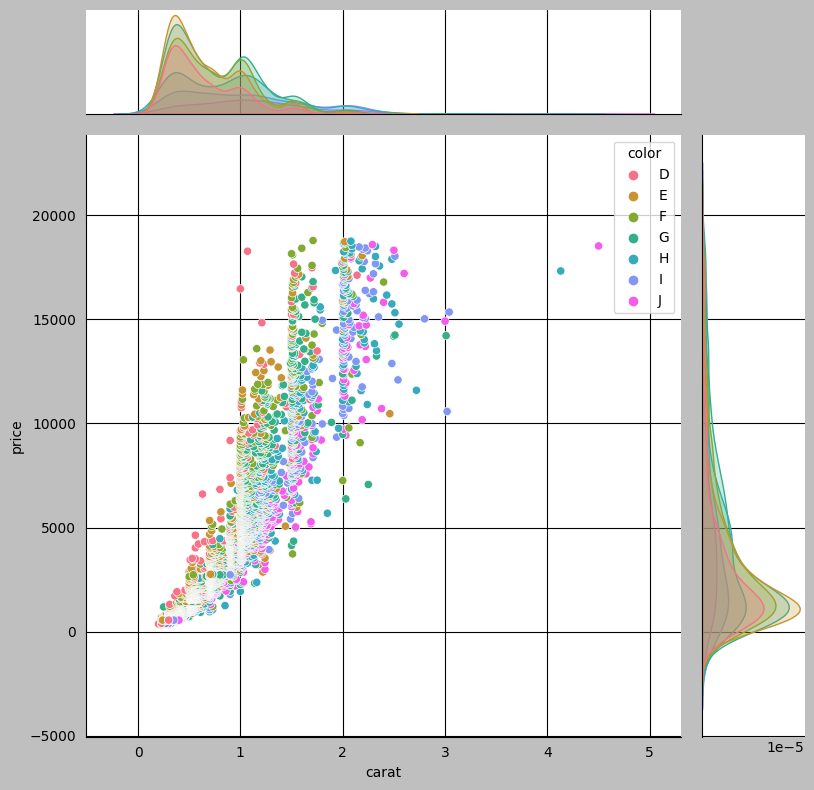

In [23]:
plt.style.use('grayscale')
sb.jointplot(x='carat', y='price', data=Df1, height=8, hue='color')

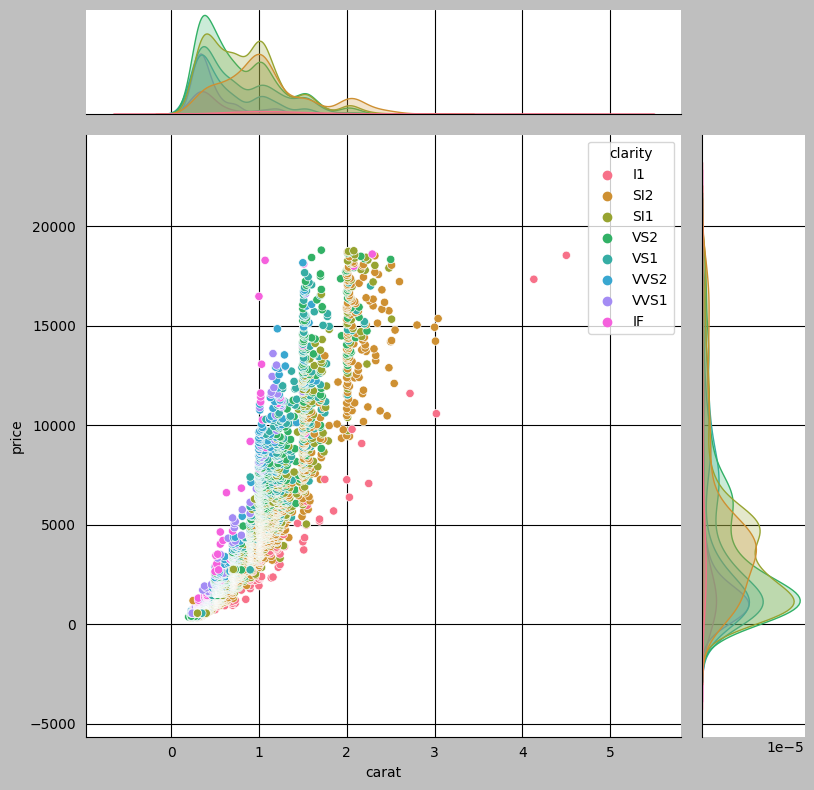

In [24]:
plt.style.use('grayscale')
sb.jointplot(x='carat', y='price', data=Df1, height=8, hue='clarity')

###Now we analyse the dimensions of the diamonds to see if they have any influence on carats and price

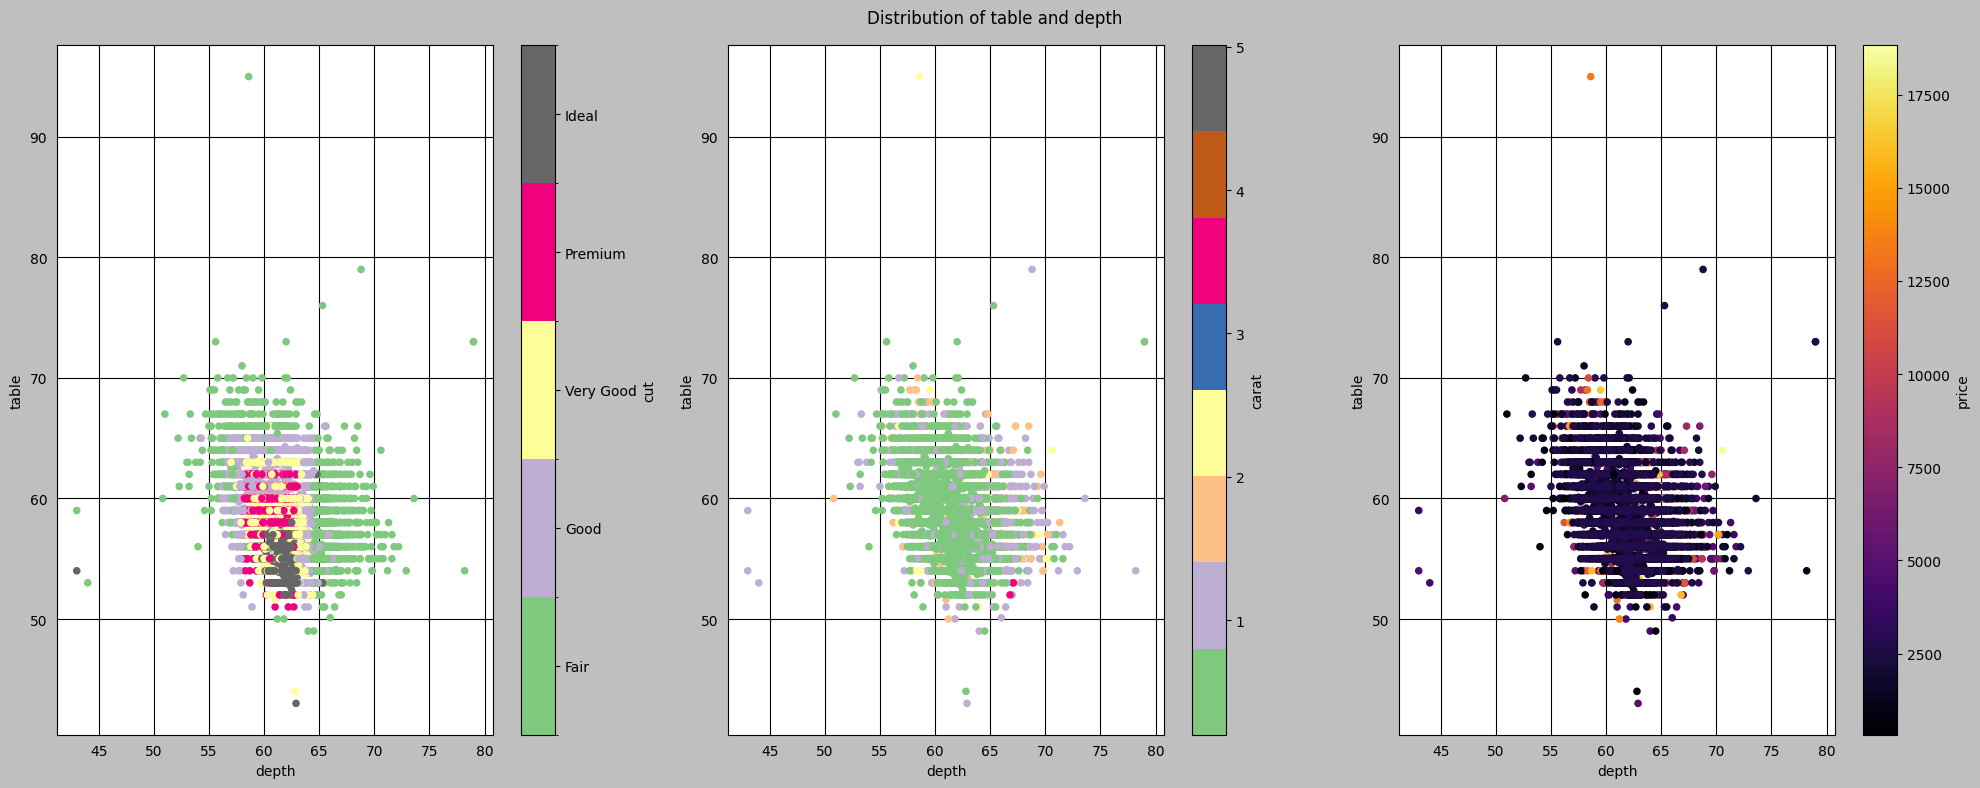

In [25]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))
Df.plot.scatter(x='depth', y='table', c='cut', cmap='Accent', ax=ax[0])
Df.plot.scatter(x='depth', y='table', c='carat', cmap='Accent', ax=ax[1])
Df.plot.scatter(x='depth', y='table', c='price', cmap='inferno', ax=ax[2])
plt.suptitle("Distribution of table and depth")
plt.tight_layout()
plt.show()

Most of the diamonds have depths and tables ranging from 55 to 70mm and 50 to 70mm respectively. The quality of the cut seems to increase as the cut and table shrink. Moreover, price and carat show no visible correlation.

Text(0.5, 0, 'Z')

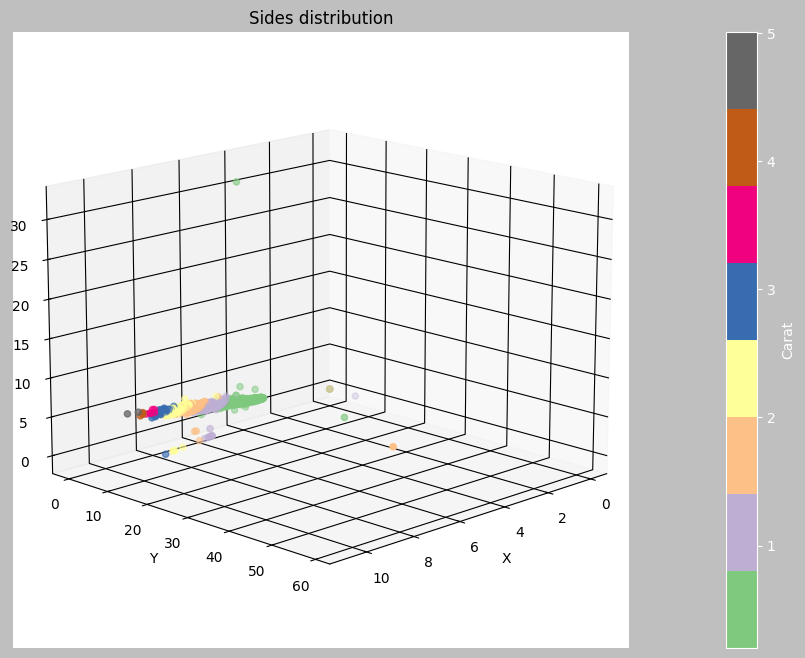

In [26]:
ax = plt.figure(figsize=(25, 8)).add_subplot(projection='3d')
scatter = ax.scatter(Df.x, Df.y, Df.z, c=Df.carat, cmap='Accent')
plt.style.use('dark_background')
plt.colorbar(scatter, label='Carat')
ax.set_title('Sides distribution')
ax.view_init(azim=45, elev=15)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


Most diamonds have their x and y axes ranging from 2 to 8mm, and the z axes ranging from 0 to 3mm respectively, with a few outliers. There is a corresponding ponding increase in carat as all three axes increase. This means that as the volume of a diamond increases, so does its weight. We also expect an increase in price too.

Let's get the volume of the diamonds by multiplying all their three axes and add it to the dataset.

In [27]:
Df['volume'] = Df.x * Df.y * Df.z
print(Df.volume.head())
print(Df.volume.describe())

0    38.202030
1    34.505856
2    38.076885
3    46.724580
4    51.917250
Name: volume, dtype: float64
count    53940.000000
mean       129.849403
std         78.245262
min          0.000000
25%         65.136830
50%        114.808572
75%        170.842451
max       3840.598060
Name: volume, dtype: float64


We conclude our EDA by looking at the correlation matrix of all the numerical features that influence price.

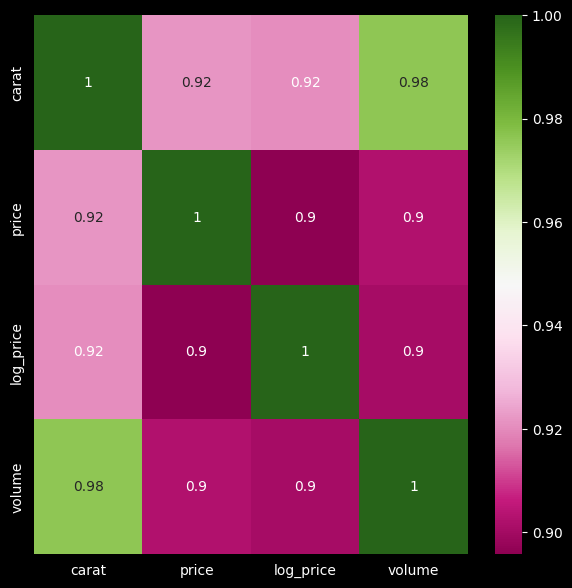

In [28]:
plt.figure(figsize=(7, 7))
data = Df[['carat', 'price', 'log_price', 'volume']]
sb.heatmap(data.corr(), annot=True, cmap='PiYG')
plt.show()


Now we see that volume and weight are very positively correlated. Ironically they are very negatively correlated with price. This means that smaller diamonds are more expensive. This means that the apparent qualities are more visible on smaller diamonds than on larger ones.

##Machine learning process
Now that we have understood our data, it is time for us to do some predictive analysis on it using machine learning algorithms.
###Polynomial Linear regression
For starters we begin with a simple regression plot

First, we have to extract only the relevant features found to be significant for our linear regression model.

In [29]:
Df_reg = data
Df_reg[Df_reg.volume > 650]

,carat,price,log_price,volume
24067,2.00,12210,9.410011,3840.598060
27415,5.01,18018,9.799127,790.133208
27630,4.50,18531,9.827200,698.455296
48410,0.51,1970,7.585789,838.502400
49189,0.51,2075,7.637716,838.502400


We found some outliers, and so we decided to remove them.

In [30]:
Df_reg.replace(Df_reg.at[24067, 'volume'], 800, inplace=True)
Df_reg.replace(Df_reg.at[48410, 'volume'], 130.0, inplace=True)
Df_reg.replace(Df_reg.at[49189, 'volume'],130.0, inplace=True)
print(Df_reg[Df_reg.volume > 700])

       carat  price  log_price      volume
24067   2.00  12210   9.410011  800.000000
27415   5.01  18018   9.799127  790.133208


<ipython-input-30-41aeba519504>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df_reg.replace(Df_reg.at[24067, 'volume'], 800, inplace=True)
<ipython-input-30-41aeba519504>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df_reg.replace(Df_reg.at[48410, 'volume'], 130.0, inplace=True)
<ipython-input-30-41aeba519504>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df_reg.replace(Df_reg.at[49189, 'volume'],130.0, inplace=True)


In [31]:
Df_reg.describe()

,carat,price,log_price,volume
count,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,3932.799722,7.786768,129.766763
std,0.474011,3989.439738,1.014649,76.529325
min,0.200000,326.000000,5.786897,0.000000
25%,0.400000,950.000000,6.856462,65.136830
50%,0.700000,2401.000000,7.783641,114.808572
75%,1.040000,5324.250000,8.580027,170.838231
max,5.010000,18823.000000,9.842835,800.000000


The shape of our data distribution is a curve. This means that a straight line might not fit into our data the way we desire, thus we will use **polynomial regression** to fit through the curve. We will use a polynomial model called a spline transformer and a simple linear predictive model to train our data.

We will use carat as our predictor, and the log of price as our output. The reason why we use the log of price is because the log of price straightens the distribution more.

In [32]:
def predict_diamond_price(col, deg=2, k=2, dim=1):

  X_Train, X_Test, y_train, y_test = train_test_split(Df_reg[col], Df_reg['log_price'], test_size=0.15, random_state=42)

  #reshape the data
  X_train = X_Train.values.reshape(-1, dim)
  X_test = X_Test.values.reshape(-1, dim)

  #create spline object
  spline = SplineTransformer(degree=deg, n_knots=k)

  #Transform and fit the data to the reshaped data to the transformer
  X_train_spline = spline.fit_transform(X_train)
  X_test_spline = spline.transform(X_test)

  #Train a linear regression model using the 
  spline_reg = LinearRegression()
  spline_reg.fit(X_train_spline, y_train)

  #implement cross validation
  scores = cross_val_score(spline_reg, X_train_spline, y_train, cv=5, scoring='r2')

  #predict the prices using the transformed test data
  y_pred = spline_reg.predict(X_test_spline)

  #get the loss functions
  r_sq = spline_reg.score(X_test_spline, y_test)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)

  #print the resulting metrics
  print('Cross-validated R-squared score:', scores.mean())
  print("Mean Squared Error:", mse)
  print("R-squared:", r_sq)
  print("Root Mean Squared Error: ", rmse)
  print("Intercept:", spline_reg.intercept_)
  print("Slope:", spline_reg.coef_)

  return X_Train, X_Test, y_train, y_test, spline, spline_reg, y_pred

We create a second model for the purpose of doing multiple linear regression using both carat and volume as our predictors. Log of price is still our target.

In [33]:
def predict_diamond_price2(deg=2, k=2, dim=1):

    #stack column and volume
  X = np.column_stack((Df_reg['volume'], Df_reg['carat']))

  #split the data
  X_Train, X_Test, y_train, y_test = train_test_split(X, Df_reg['log_price'], test_size=0.15, random_state=42)

  #reshape the data
  X_train = X_Train.reshape(-1, dim)
  X_test = X_Test.reshape(-1, dim)

  #create spline object
  spline = SplineTransformer(degree=deg, n_knots=k)

  #Transform and fit the data to the reshaped data to the transformer
  X_train_spline = spline.fit_transform(X_train)
  X_test_spline = spline.transform(X_test)

  #Train a linear regression model using the 
  spline_reg = LinearRegression()
  spline_reg.fit(X_train_spline, y_train)

  #implement cross validation
  scores = cross_val_score(spline_reg, X_train_spline, y_train, cv=5, scoring='r2')

  #predict the prices using the transformed test data
  y_pred = spline_reg.predict(X_test_spline)

  #get the loss functions
  r_sq = spline_reg.score(X_test_spline, y_test)
  mse = mean_squared_error(y_test, y_pred)
  rmse = np.sqrt(mse)

  #print the resulting metrics
  print('Cross-validated R-squared score:', scores.mean())
  print("Mean Squared Error:", mse)
  print("R-squared:", r_sq)
  print("Root Mean Squared Error: ", rmse)
  print("Intercept:", spline_reg.intercept_)
  print("Slope:", spline_reg.coef_)

  return X_Train, X_Test, y_train, y_test, spline, spline_reg, y_pred

Then for the purposes of multiple linear regression, we zip the diamonds with their individual carats and volume into one list of diamonds.

In [34]:
diamonds = [(carat, volume) for carat, volume in zip(Df_reg['carat'], Df_reg['volume'])]

Next we create a function to transform the diamonds, then predict the log of the prices based on the model. Then converts them from log_prices back to prices.

In [35]:
def predict_diamond_price_distribution(model, features, dim=1):
  
  # Convert features to array and reshape
  features = np.array(features).reshape(-1, dim)

  #transform features
  transformed_features = model[4].transform(features)

  # Use the model to predict the log prices
  log_prices = model[5].predict(transformed_features)
  
  #convert the log back to prices
  prices = np.exp(log_prices)
  
  # Return the predicted prices
  return np.round(prices, 2), np.round(log_prices, 2)

Then we create new instances for test.

In [36]:
#predict diamond prices based on carat
print("Evaluation for price against carat")
price_carat = predict_diamond_price('carat')
c_diamond = predict_diamond_price_distribution(price_carat, list(Df_reg['carat']))

#predict diamond prices based on volume
print("\n\nEvaluation of price against volume")
price_volume = predict_diamond_price('volume')
v_diamond = predict_diamond_price_distribution(price_volume, list(Df_reg['volume']))

#predict diamond prices based on both cara and volume
print("\n\nEvaluation for price against carat and volume")
price2d_diamond = predict_diamond_price2(dim=2)
d2_diamond = predict_diamond_price_distribution(price2d_diamond, diamonds, 2)

Evaluation for price against carat
Cross-validated R-squared score: 0.9293362227760749
Mean Squared Error: 0.07346258001384913
R-squared: 0.9289333066717247
Root Mean Squared Error:  0.2710398125992732
Intercept: 366317726.46216655
Slope: [-3.66317729e+08 -3.66317712e+08 -3.66317737e+08]


Evaluation of price against volume
Cross-validated R-squared score: 0.9256043735377901
Mean Squared Error: 0.07261811954626819
R-squared: 0.9297502261573473
Root Mean Squared Error:  0.26947749358020273
Intercept: 9768575722.188688
Slope: [-9.76857573e+09 -9.76857571e+09 -9.76857573e+09]


Evaluation for price against carat and volume
Cross-validated R-squared score: 0.9288103805697456
Mean Squared Error: 0.0726607994909881
R-squared: 0.9297089381636217
Root Mean Squared Error:  0.2695566721322032
Intercept: -5075497318305.394
Slope: [ 5.23944063e+12  5.23944063e+12  5.23944063e+12 -1.63943314e+11
 -1.63943314e+11 -1.63943314e+11]




---

We can see that we have satisfactory R^2, MSE, and RMSE values. We expect satisfactory predictions on any distribution.

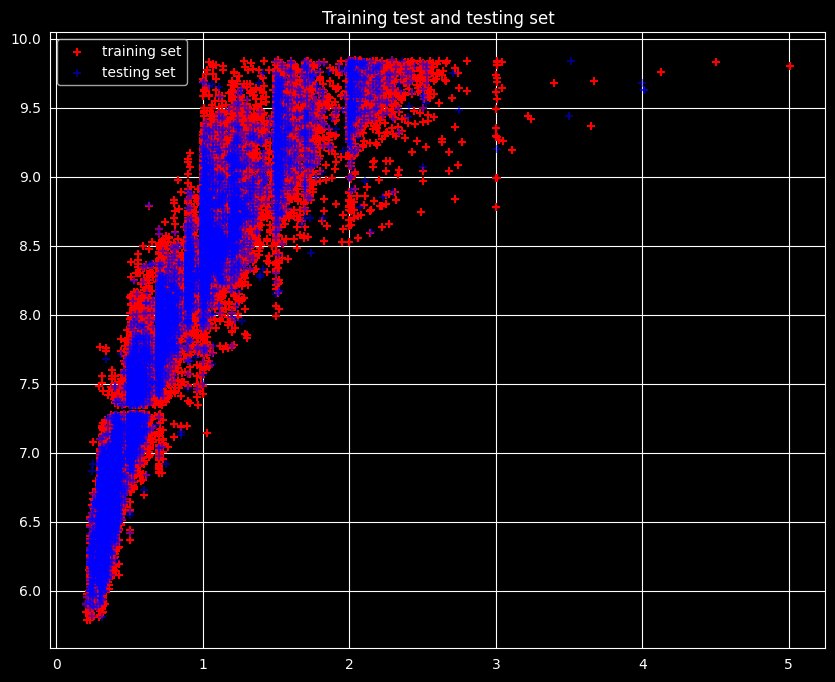

In [37]:
fig, ax = plt.subplots(figsize=(10, 8))
# ax.scatter(X_Train, y_train, color='red', marker='+', label='training set')
ax.scatter(price_carat[0], price_carat[2], color='red', marker='+', label='training set')
#  ax.scatter(X_Train, x_Test, color='red', marker='+', label='training set')
ax.scatter(price_carat[1], price_carat[3], color='blue', marker='+', alpha=0.5, label='testing set')
ax.set_title("Training test and testing set")
ax.legend()

Now let us see how our model performs on the test set.

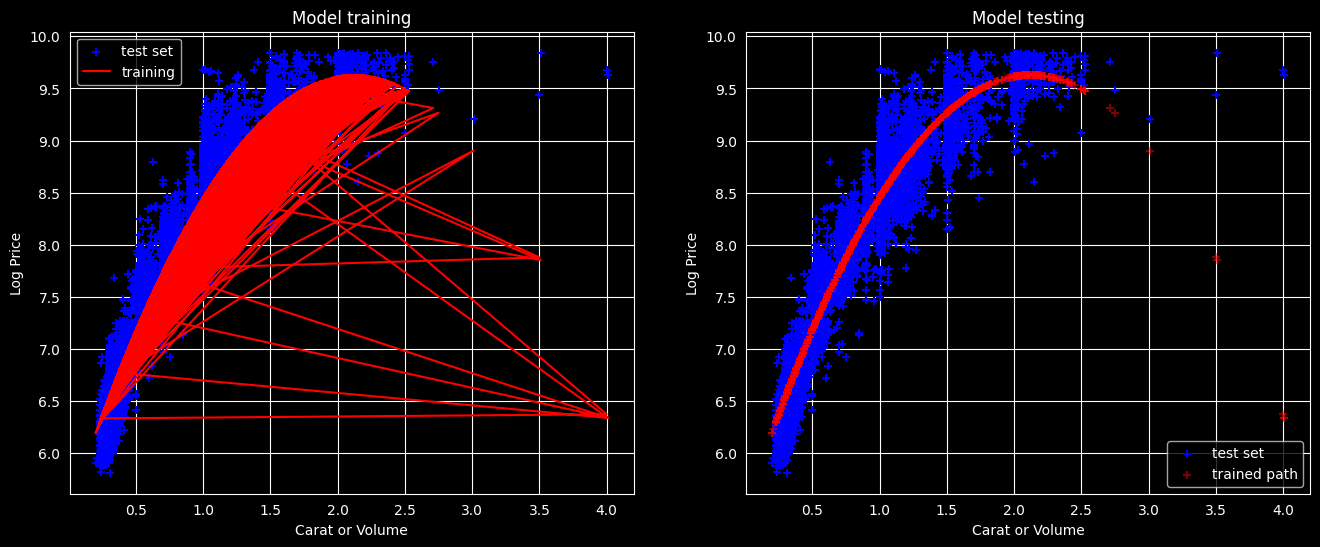

In [38]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].scatter(price_carat[1], price_carat[3], color='blue', marker='+', label='test set')
ax[0].plot(price_carat[1], price_carat[6], color='red', label='training')
ax[0].set_title('Model training')
ax[0].set_xlabel('Carat or Volume')
ax[0].set_ylabel('Log Price')
ax[0].legend()

ax[1].scatter(price_carat[1], price_carat[3], color='blue', marker='+', label='test set')
ax[1].scatter(price_carat[1], price_carat[6], color='red', marker='+', alpha=0.5, label='trained path')
ax[1].set_title('Model testing')
ax[1].set_xlabel('Carat or Volume')
ax[1].set_ylabel('Log Price')
ax[1].legend()

We can see that the test path fits with the form a 2-degree plynomial.


---

Now let us see how well our model does with the original price distribution

Mean of actual distribution: 3932.799721913237
Standard deviation of actual distribution: 3989.439738146379


With carat
Mean of predicted distribution: 3853.257236744531
Standard deviation of predicted distribution: 3819.9917167651092


With volume
Mean of predicted distribution: 3854.6580643307375
Standard deviation of predicted distribution: 3847.8407323176193


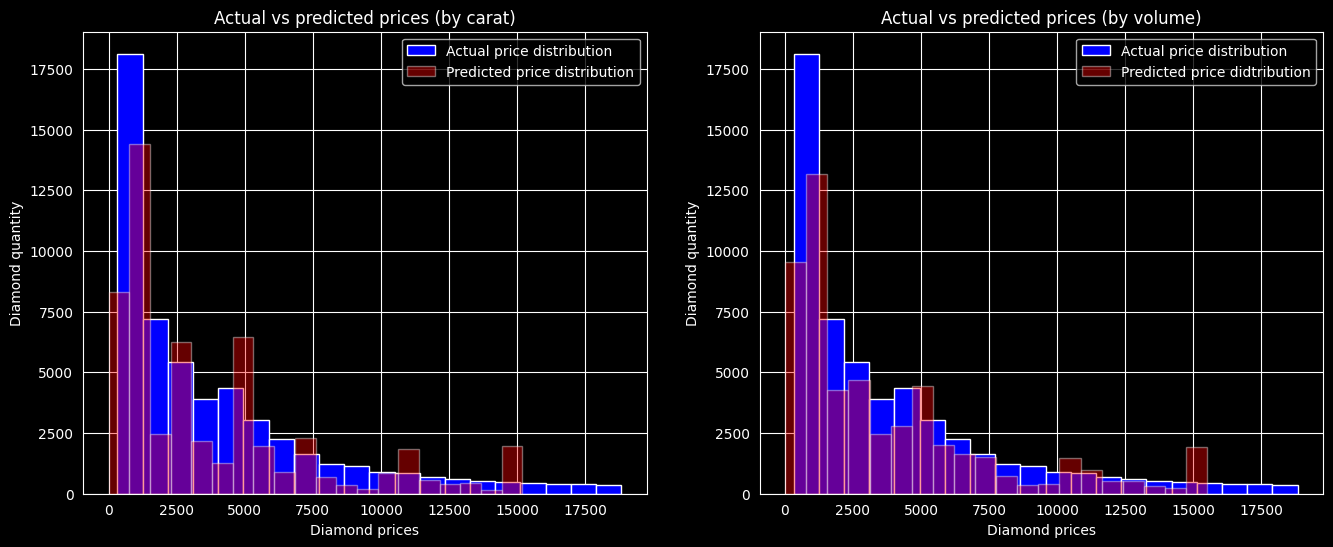

In [39]:
fig, ax = plt.subplots(1, 2, figsize=(16, 6))

ax[0].hist(Df_reg['price'], color='blue', bins=20, label='Actual price distribution')
ax[0].hist(c_diamond[0], color='red', alpha=0.4, bins=20, label='Predicted price distribution')
ax[0].set_title('Actual vs predicted prices (by carat)')
ax[0].set_xlabel('Diamond prices')
ax[0].set_ylabel('Diamond quantity')
ax[0].legend()

ax[1].hist(Df_reg['price'], color='blue', bins=20, label='Actual price distribution')
ax[1].hist(v_diamond[0], color='red', alpha=0.4, bins=20, label='Predicted price didtribution')
ax[1].set_title('Actual vs predicted prices (by volume)')
ax[1].set_xlabel('Diamond prices')
ax[1].set_ylabel('Diamond quantity')
ax[1].legend()

print("Mean of actual distribution:", Df_reg['price'].mean())
print("Standard deviation of actual distribution:", Df_reg['price'].std())

print("\n\nWith carat")
print("Mean of predicted distribution:", c_diamond[0].mean())
print("Standard deviation of predicted distribution:", c_diamond[0].std())

print("\n\nWith volume")
print("Mean of predicted distribution:", v_diamond[0].mean())
print("Standard deviation of predicted distribution:", v_diamond[0].std())

We can see the results of our model. It could predict the prices so well with a mean difference and std difference with a tiny margin of error.

Now let us plot a 3D distribution of our predictions on price, volume, and price. We reduce the sample size by the 20th quantile in order to save memory

Cross-validated R-squared score: 0.9288103805697456
Mean Squared Error: 0.0726607994909881
R-squared: 0.9297089381636217
Root Mean Squared Error:  0.2695566721322032
Intercept: -5075497318305.394
Slope: [ 5.23944063e+12  5.23944063e+12  5.23944063e+12 -1.63943314e+11
 -1.63943314e+11 -1.63943314e+11]


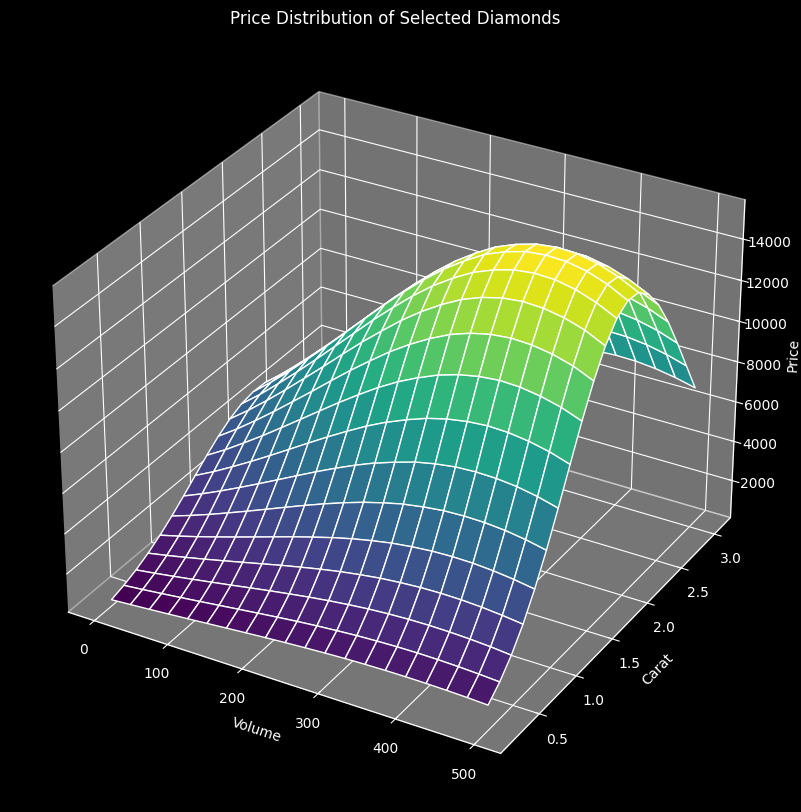

In [40]:
Df_selected = Df_reg.iloc[::20, :].reset_index(drop=True)

# create a meshgrid of volume and carat values
volume = np.linspace(Df_selected['volume'].min(), Df_selected['volume'].max(), 20)
carat = np.linspace(Df_selected['carat'].min(), Df_selected['carat'].max(), 20)
Volume, Carat = np.meshgrid(volume, carat)

# predict the price using the trained model
diamonds = predict_diamond_price2(dim=2)
X = np.column_stack((Volume.ravel(), Carat.ravel()))
price = predict_diamond_price_distribution(diamonds, X, 2)
Price = np.array(price[0].reshape(20, 20))

# plot the 3D meshgrid
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(Volume, Carat, Price, cmap='viridis')
ax.set_xlabel('Volume')
ax.set_ylabel('Carat')
ax.set_zlabel('Price')
ax.set_title('Price Distribution of Selected Diamonds')
plt.show()

### Random forest

Now let us try a diffeerent model that will work on both our categorical and numeric values.

In [41]:
Df_rt = Df[['cut', 'color', 'clarity', 'carat', 'volume', 'price', 'log_price']]

Once again we will edit the few hazardous outliers.

In [42]:
Df_rt.replace(Df_rt.at[24067, 'volume'], 800, inplace=True)
Df_rt.replace(Df_rt.at[48410, 'volume'], 130.0, inplace=True)
Df_rt.replace(Df_rt.at[49189, 'volume'],130.0, inplace=True)

<ipython-input-42-c20264b87a9b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df_rt.replace(Df_rt.at[24067, 'volume'], 800, inplace=True)
<ipython-input-42-c20264b87a9b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df_rt.replace(Df_rt.at[48410, 'volume'], 130.0, inplace=True)
<ipython-input-42-c20264b87a9b>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Df_rt.replace(Df_rt.at[49189, 'volume'],130.0, inplace=True)


In [43]:
Df_rt.describe()

,carat,volume,price,log_price
count,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,129.766763,3932.799722,7.786768
std,0.474011,76.529325,3989.439738,1.014649
min,0.200000,0.000000,326.000000,5.786897
25%,0.400000,65.136830,950.000000,6.856462
50%,0.700000,114.808572,2401.000000,7.783641
75%,1.040000,170.838231,5324.250000,8.580027
max,5.010000,800.000000,18823.000000,9.842835


We first use GridSearch to estimate the right hyperparameters that will fit into our model

In [45]:
# # Split the data into training and testing sets
# X = Df_rt.drop(columns=['price', 'log_price'])
# y = Df_rt['log_price']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# encoder = OrdinalEncoder(categories='auto')
# X_train[['cut', 'color', 'clarity']] = encoder.fit_transform(X_train[['cut', 'color', 'clarity']])
# X_test[['cut', 'color', 'clarity']] = encoder.transform(X_test[['cut', 'color', 'clarity']])

# # Set up the parameter grid for the random forest regressor
# param_grid = {
#   'n_estimators': [100, 150, 200],
#   'max_depth': [5, 10, 15]
# }

# # Initialize the random forest regressor
# rf = RandomForestRegressor(random_state=42)

# kfold=KFold(n_splits=5)
# # Set up the GridSearchCV object
# grid_search = GridSearchCV(rf, param_grid, cv=kfold, scoring='r2', n_jobs=-1, verbose=2)

# # Start timer and fit the GridSearchCV object to the training data
# start_time = time.time()
# grid_search.fit(X_train, y_train)
# end_time = time.time()

# # Make predictions on the testing data
# y_pred = grid_search.predict(X_test)

# # Evaluate the performance of the random forest regressor using mean squared error
# mse = mean_squared_error(y_test, y_pred)
# rmse = mse**0.5

# # Print the results
# print(f"Grid search took {end_time - start_time:.2f} seconds to complete.")
# print("Best parameters:", grid_search.best_params_)
# print("Best mean squared error:", grid_search.best_score_)
# print("Random Forest Root Mean Squared Error", rmse)
# print('\n\n')

# for i, params in enumerate(grid_search.cv_results_['params']):
#   print("Estimator:", params)
#   print("Mean score:", grid_search.cv_results_['mean_test_score'][i])
#   print("Std score", grid_search.cv_results_['std_test_score'][i])

Based on the results we obtained from the grid search, we will use ordinal encoder to encode our categorical values because they have rank. Then we will use an instance of a random forest regressor to train our dataset. Then we will print out the scores.

In [46]:
# Split the data into training and testing sets
X = Df_rt.drop(columns=['price', 'log_price', 'volume'])
y = Df_rt['log_price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

encoder = OrdinalEncoder(categories='auto')
X_train[['cut', 'color', 'clarity']] = encoder.fit_transform(X_train[['cut', 'color', 'clarity']])
X_test[['cut', 'color', 'clarity']] = encoder.transform(X_test[['cut', 'color', 'clarity']])

# Initialize the random forest regressor
rf = RandomForestRegressor(n_estimators=200, oob_score=True, max_depth=15, random_state=42)

start_time = time.time()
rf.fit(X_train, y_train)

kfold=KFold(n_splits=5)
# Cross validate
scores = cross_validate(
  estimator=rf, X=X_train, y=y_train, cv=kfold, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)

end_time = time.time()
# Make predictions on the testing data
y_pred = rf.predict(X_test)

# Evaluate the performance of the random forest regressor using mean squared error
mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5

# Print the results
print(f"Training took {end_time - start_time:.2f} seconds to complete.")
print("Random forest score", rf.score(X_train, y_train))
print("OOB Score", rf.oob_score_)
print("OOB error", 1 - rf.oob_score_)
print("Random forest mean squared error:", mse)
print("Random forest root mean squared Error", rmse)
print("Cross validation mean squared error:", -1*scores['test_score'])
print("Cross validation root mean squared error:", (-1*scores['test_score'])**0.5)

# Get feature importances
importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': rf.feature_importances_})
importances = importances.sort_values('Importance', ascending=False)

print('\nFeature Importances:') 
print(importances)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   29.1s finished


Training took 39.99 seconds to complete.
Random forest score 0.9929323545011653
OOB Score 0.9892746535124302
OOB error 0.010725346487569842
Random forest mean squared error: 0.01112255905358705
Random forest root mean squared Error 0.10546354371813536
Cross validation mean squared error: [0.01121723 0.01189044 0.01142733 0.01103934 0.01090279]
Cross validation root mean squared error: [0.10591143 0.10904328 0.10689871 0.10506825 0.10441644]

Feature Importances:
   Feature  Importance
3    carat    0.947319
2  clarity    0.034327
1    color    0.015358
0      cut    0.002996


Our model seems to have trained the data almost perfectly.
Moreover, it seems that the influence of the categorical features don't have much say in determining price like carat (or volume) does.

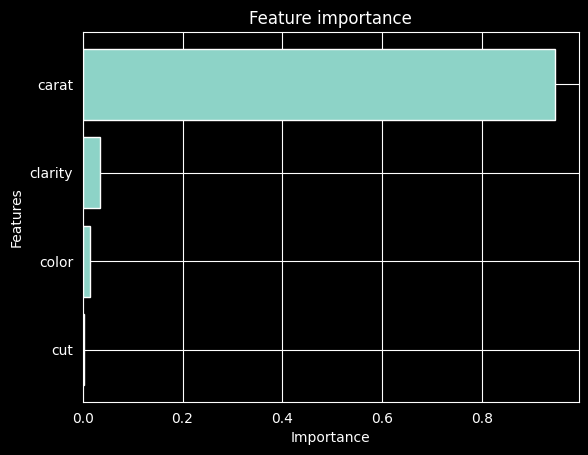

In [47]:
# Get feature importances and sort them in descending order
importances = rf.feature_importances_
indices = np.argsort(importances)
features = X_train.columns

# Plot feature importances
plt.figure()
plt.title("Feature importances")
plt.barh(range(X_train.shape[1]), importances[indices], align="center")
plt.yticks(range(X_train.shape[1]), [features[i] for i in indices])
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature importance")
plt.show()

Now let us test and see how our model behaves on the original price distribution.

In [48]:
# create a copy of the original dataframe
df_ord = Df_rt.copy().drop(columns=['price', 'log_price', 'volume'])

# select the categorical columns
cat_cols = ['cut', 'color', 'clarity']

# fit and transform the categorical columns
df_ord[cat_cols] = encoder.fit_transform(df_ord[cat_cols])

# display the encoded dataset
print(df_ord.head())

   cut  color  clarity  carat
0  2.0    1.0      3.0   0.23
1  3.0    1.0      2.0   0.21
2  1.0    1.0      4.0   0.23
3  3.0    5.0      5.0   0.29
4  1.0    6.0      3.0   0.31


In [49]:
predicted_prices = np.exp(rf.predict(df_ord))

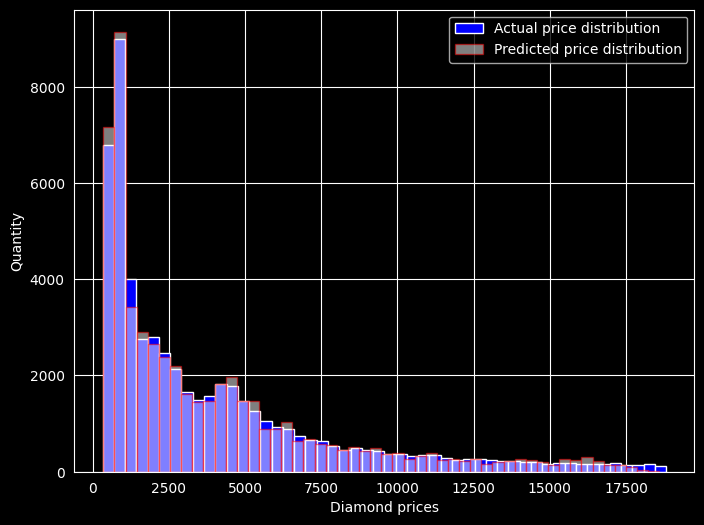

In [50]:
plt.figure(figsize=(8, 6))
plt.hist(
  Df_rt['price'], color='blue', bins=50, label='Actual price distribution')
plt.hist(
  predicted_prices, color='white', edgecolor='red', alpha=0.5,
  bins=50, label='Predicted price distribution')
plt.xlabel('Diamond prices')
plt.ylabel('Quantity')
plt.legend()
plt.show()

In [70]:
print("Mean of actual price distribution", round(Df_rt['price'].mean(), 2))
print("Mean of predicted price distribution", round(predicted_prices.mean(), 2))

print("\nStandard deviation of actual price distribution", round(Df_rt['price'].std(), 2))
print("Standard deviation of predicted price distribution", round(predicted_prices.std(), 2))

Mean of actual price distribution 3932.8
Mean of predicted price distribution 3917.5

Standard deviation of actual price distribution 3989.44
Standard deviation of predicted price distribution 3941.67


In [71]:
# Calculate the percentage error of the mean difference
mean_diff_error = abs(predicted_prices.mean() - Df_rt['price'].mean()) / Df_rt['price'].mean() * 100

# Calculate the percentage error of the standard deviation difference
std_diff_error = abs(predicted_prices.std() - Df_rt['price'].std()) / Df_rt['price'].std() * 100

print("Percentage error of mean difference: {:.2f}%".format(mean_diff_error))
print("Percentage error of std difference: {:.2f}%".format(std_diff_error))

Percentage error of mean difference: 0.39%
Percentage error of std difference: 1.20%


Our random forest regressor model did better than the linear regression model because it could capture more datapoints accurately and still overcome the problem of overfitting.


---

Now let's create a function that will tell us the price of a new diamond that have the relevant feature qualities.

In [53]:
def assume_diamond_price(cut, color, clarity, carat):
  # create a new DataFrame for our diamond with the same columns as our training data
  new_diamond = pd.DataFrame(columns=['cut', 'color', 'clarity', 'carat'])

  # fill in the values for our new diamond
  new_diamond.loc[0, 'cut'] = cut
  new_diamond.loc[0, 'color'] = color
  new_diamond.loc[0, 'clarity'] = clarity
  new_diamond.loc[0, 'carat'] = carat


  # replace the categorical features with their encoded values
  new_diamond[['cut', 'color', 'clarity']] = encoder.transform(new_diamond[['cut', 'color', 'clarity']])

  # use our trained random forest model to predict the price of the new diamond
  new_diamond_pred = rf.predict(new_diamond)

  return np.exp(new_diamond_pred)[0]

In [54]:
jewel = assume_diamond_price(cut='Ideal', color='J', clarity='IF', carat=0.0)
print(f"This diamond cost ${jewel:.2f}")

This diamond cost $459.41


Later we will deploy this model to a web app that will utilize the two models to predict the price of a diamond.